In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Import some useful packages
import matplotlib.pyplot as plt
import numpy as np
from ipywidgets import interact, IntSlider, FloatSlider

import tensorflow as tf
import tensorflow.keras.backend as K

# Layers for FNN
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Lambda, concatenate
from tensorflow.keras.layers import Dense

# Optimizers for training
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras import metrics

# Losses for training
from tensorflow.keras import losses

# For data preprocessing
from tensorflow.keras import datasets
from tensorflow.keras.utils import to_categorical

In [4]:
# Load dataset
(X_train, y_train0), (X_test, y_test0) = datasets.mnist.load_data()

# Reshape size
X_train = X_train.reshape(-1, 28*28)
X_test = X_test.reshape(-1, 28*28)

# Normalize the range of featurs
X_train = X_train / X_train.max()
X_test = X_test / X_test.max()

# One-hot encoding
y_train = to_categorical(y_train0, 10)
y_test = to_categorical(y_test0, 10)

* VAE有兩大重點：1.神經網路裡面可以加入抽樣 2.進行重參數化

In [23]:
enc_1 = Dense(200, activation='sigmoid')

enc_mean = Dense(2)
enc_log_var = Dense(2)

dec_2 = Dense(200, activation='sigmoid')
dec_1 = Dense(784, activation='sigmoid')

In [24]:
x = Input(shape=(784,))
enc_x = enc_1(x)

z_mean = enc_mean(enc_x)
z_log_var = enc_log_var(enc_x)

In [25]:
def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [26]:
# Sampling function wrapped as a Keras layer
z = Lambda(sampling, output_shape=(2,))([z_mean, z_log_var])

In [27]:
# Define Decoder part of VAE
z_input = Input(shape=(2,))
x_hat = dec_1(dec_2(z_input))

In [28]:
x_hat = dec_1(dec_2(z))

VAE = Model(x, x_hat)
VAE.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 784)]        0                                            
__________________________________________________________________________________________________
dense_5 (Dense)                 (None, 200)          157000      input_3[0][0]                    
__________________________________________________________________________________________________
dense_6 (Dense)                 (None, 2)            402         dense_5[0][0]                    
__________________________________________________________________________________________________
dense_7 (Dense)                 (None, 2)            402         dense_5[0][0]                    
____________________________________________________________________________________________

In [29]:
reconstruction_loss = 784 * losses.mean_squared_error(x, x_hat)

kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5

vae_loss = K.mean(reconstruction_loss + kl_loss)

VAE.add_loss(vae_loss)

In [30]:
VAE.compile(loss='MAE',
                    optimizer=Adam(6e-4),
                    metrics=['mse'])

# VAE.load_weights('VAE_handwriting_model_weights.h5')

In [31]:
VAE.fit(X_train, X_train, 
        batch_size=256, 
        epochs=20)

Train on 60000 samples
Epoch 1/20
60000/60000 [==============================] - 4s 73us/sample - loss: 61.9249 - mse: 0.0785
Epoch 2/20
60000/60000 [==============================] - 3s 53us/sample - loss: 51.2240 - mse: 0.0638
Epoch 3/20
60000/60000 [==============================] - 3s 53us/sample - loss: 49.0312 - mse: 0.0602
Epoch 4/20
60000/60000 [==============================] - 3s 55us/sample - loss: 47.7942 - mse: 0.0581
Epoch 5/20
60000/60000 [==============================] - 3s 53us/sample - loss: 47.2559 - mse: 0.0573
Epoch 6/20
60000/60000 [==============================] - 3s 52us/sample - loss: 46.9702 - mse: 0.0569
Epoch 7/20
60000/60000 [==============================] - 3s 52us/sample - loss: 46.8338 - mse: 0.0567
Epoch 8/20
60000/60000 [==============================] - 3s 52us/sample - loss: 46.7593 - mse: 0.0566
Epoch 9/20
60000/60000 [==============================] - 3s 52us/sample - loss: 46.6964 - mse: 0.0564
Epoch 10/20
60000/60000 [=========================

In [49]:
VAE.save_weights('VAE_model_weights4.h5')

In [32]:
VAE_Encoder = Model(x, z_mean)

VAE_Encoder.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense_5 (Dense)              (None, 200)               157000    
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 402       
Total params: 157,402
Trainable params: 157,402
Non-trainable params: 0
_________________________________________________________________


In [33]:
VAE_Decoder = Model(z_input, dec_1(dec_2(z_input)))

VAE_Decoder.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_8 (Dense)              (None, 200)               600       
_________________________________________________________________
dense_9 (Dense)              (None, 784)               157584    
Total params: 158,184
Trainable params: 158,184
Non-trainable params: 0
_________________________________________________________________


In [34]:
idx = np.random.randint(X_train.shape[0])
print(f"第 {idx} 圖的 latent 表示為 {VAE_Encoder.predict(X_train[idx: idx+1]).squeeze()}")


第 34824 圖的 latent 表示為 [1.2871062 1.4902318]


In [35]:
indice = np.random.randint(X_train.shape[0],size=5000)

In [36]:
VAE_Encoder.predict(X_train[indice])

array([[-0.5807462 ,  1.3680214 ],
       [ 0.01424997, -1.6037406 ],
       [-0.78499854, -1.1928841 ],
       ...,
       [ 1.6302158 , -0.97206944],
       [-1.9872519 , -0.47485122],
       [ 0.94132006,  0.97517586]], dtype=float32)

In [37]:
VAE_latents = VAE_Encoder.predict(X_train[indice])

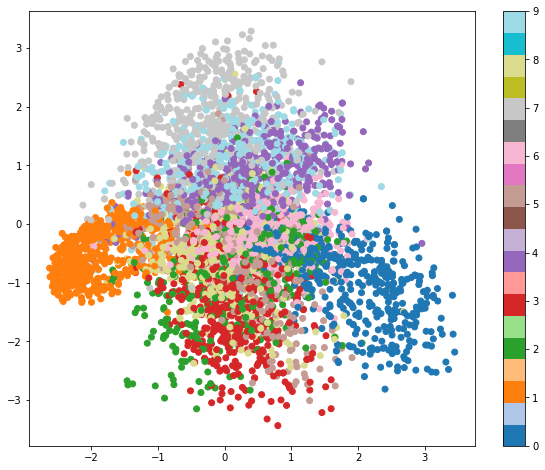

In [38]:
plt.figure(figsize=(10, 8))
plt.scatter(VAE_latents[:, 0], VAE_latents[:, 1], c=y_train0[indice], cmap='tab20')
plt.colorbar()
plt.show()

In [92]:
def normalized(x):
    x -= x.min()
    x /= x.max()
    return x